# Cross-validation with Chronos

Peixero github: https://github.com/marcopeix/TimeSeriesForecastingUsingFoundationModels/blob/main/CH05/CH05.ipynb

Chronos github: https://github.com/amazon-science/chronos-forecasting/tree/mlx

In [1]:
# Packages
import numpy as np
from chronos_mlx import ChronosPipeline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import yfinance as yf

### Functions

In [2]:
# Load the Chronos pipeline (MLX version for Apple Silicon)
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",  # other sizes: chronos-t5-mini, -base, -large
    dtype="bfloat16",           # required for MLX
)

In [3]:
# Chronos forecast function using sequential index (no dates)
def forecast_chronos(series, pipeline, context_length=66, prediction_days=22,
                     n_samples=100, temperature=1.0, top_k=50, top_p=1.0):
    """
    Forecast future paths from a simulated series using Chronos (MLX version).

    Parameters:
    - series: pd.Series, the simulated price series
    - pipeline: ChronosPipeline (MLX)
    - context_length: number of past points to condition on
    - prediction_days: number of steps ahead to forecast
    - n_samples: number of trajectories to sample
    - temperature, top_k, top_p: sampling controls

    Returns:
    - low, median, high: 10-50-90 percentiles (np.ndarrays)
    - samples: all forecast paths
    - base_price: last actual value used for forecasting
    """
    context_array = series[-context_length:].values

    forecasts = pipeline.predict(
        context=context_array,
        prediction_length=prediction_days,
        num_samples=n_samples,
        temperature=temperature,
        top_k=top_k,
        top_p=top_p,
    )

    samples = forecasts[0]  # shape: [n_samples, prediction_days]
    low, median, high = np.quantile(samples, [0.1, 0.5, 0.9], axis=0)

    return low, median, high, samples, context_array[-1]

In [4]:
# Cross-validation function for Chronos
def chronos_cv_min(
    series: pd.Series,
    forecaster_function,
    pipeline,
    context_length: int,
    prediction_days: int,
    number_windows: int,
    number_samples: int = 100,
    sampling_kwargs: dict | None = None,
):
    """
    Rolling-block cross-validation for Chronos/TSFM forecasters.

    Parameters
    ----------
    series : pd.Series
        Univariate series (DatetimeIndex or RangeIndex).
    forecaster_function : callable
        Returns (low, median, high, samples, base_value) given
        (series, pipeline, context_length, prediction_days, n_samples, **kwargs).
    pipeline : object
        Loaded Chronos pipeline (MLX or other backend).
    context_length : int
        Past points used as model context before each forecast.
    prediction_days : int
        Forecast horizon per window.
    number_windows : int
        How many non-overlapping forecast windows to evaluate (step = prediction_days).
    number_samples : int
        Number of sampled forecast paths per window.
    sampling_kwargs : dict, optional
        Extra kwargs passed to forecaster_function (e.g., temperature, top_k, top_p).

    Returns
    -------
    evaluation_dataframe : pd.DataFrame
        Columns ["true","low","median","high"] over the concatenated CV evaluation span.
    metrics : dict
        {
          "overall_mse", "overall_rmse", "overall_mae",
          "overall_mape", "overall_smape", "coverage",
          "window_mse": List[float]  # per-window MSEs
        }
    """
    if sampling_kwargs is None:
        sampling_kwargs = {}

    need = context_length + number_windows * prediction_days
    if len(series) < need:
        raise ValueError(f"Series too short (need {need}, have {len(series)})")

    lows_all, meds_all, highs_all, trues_all = [], [], [], []
    window_mse = []

    for i in range(number_windows, 0, -1):
        history_end = -(prediction_days * i)
        history_series = series.iloc[:history_end]

        low, median, high, samples, _ = forecaster_function(
            series=history_series,
            pipeline=pipeline,
            context_length=context_length,
            prediction_days=prediction_days,
            n_samples=number_samples,
            **sampling_kwargs,
        )

        true_start = -(prediction_days * i)
        true_end = -(prediction_days * (i - 1)) if (i - 1) > 0 else None
        true_block = series.iloc[true_start:true_end].to_numpy()

        low = np.asarray(low, dtype=float).reshape(-1)
        median = np.asarray(median, dtype=float).reshape(-1)
        high = np.asarray(high, dtype=float).reshape(-1)
        true_block = np.asarray(true_block, dtype=float).reshape(-1)

        window_mse.append(float(np.mean((true_block - median) ** 2)))

        lows_all.append(low)
        meds_all.append(median)
        highs_all.append(high)
        trues_all.append(true_block)

    lows = np.concatenate(lows_all).reshape(-1)
    meds = np.concatenate(meds_all).reshape(-1)
    highs = np.concatenate(highs_all).reshape(-1)
    trues = np.concatenate(trues_all).reshape(-1)

    eval_index = series.index[-(number_windows * prediction_days):]
    evaluation_dataframe = pd.DataFrame(
        {"true": trues, "low": lows, "median": meds, "high": highs},
        index=eval_index,
    )

    mse = float(np.mean((trues - meds) ** 2))
    rmse = float(np.sqrt(mse))
    mae = float(np.mean(np.abs(trues - meds)))
    mape = float(np.mean(np.abs((trues - meds) / trues))) * 100.0
    smape = float(np.mean(2.0 * np.abs(trues - meds) / (np.abs(trues) + np.abs(meds)))) * 100.0
    coverage = float(np.mean((trues >= lows) & (trues <= highs))) * 100.0

    metrics = {
        "overall_mse": mse,
        "overall_rmse": rmse,
        "overall_mae": mae,
        "overall_mape": mape,
        "overall_smape": smape,
        "coverage": coverage,
        "window_mse": window_mse,
    }
    return evaluation_dataframe, metrics

In [21]:
def plot_forecast_eval(series: pd.Series, eval_df: pd.DataFrame, title: str, prediction_days: int):
    """
    Plot continuous true series in black.
    For each forecast window:
      - black dot at forecast origin (true last actual point before forecast)
      - dashed median forecast line starting from that dot through forecast horizon
      - shaded CI within forecast horizon
    Legend is shown once (Actual, Forecast origin, Median forecast, 10–90% CI).
    """
    fig, ax = plt.subplots(figsize=(14, 6))

    # Actual series (continuous line)
    actual_line, = ax.plot(series.index, series.values, color="black", lw=1.25, label="Actual")

    # Infer number of windows
    number_windows = len(eval_df) // prediction_days

    # Placeholders for legend handles
    median_handle = None
    ci_handle = None
    origin_handle = None

    # Split into forecast blocks
    for i in range(number_windows):
        block = eval_df.iloc[i * prediction_days:(i + 1) * prediction_days]

        forecast_start = block.index[0]
        prev_date = series.index[series.index.get_loc(forecast_start) - 1]
        last_actual = float(series.loc[prev_date].iloc[0])  # safe scalar

        # Black dot at forecast origin (true value)
        origin_dot, = ax.plot(prev_date, last_actual, marker="o", color="black", ms=5, zorder=3)
        if origin_handle is None:
            origin_handle = origin_dot

        # Median forecast line, continuous from last actual
        median_line, = ax.plot(
            [prev_date] + list(block.index),
            [last_actual] + list(block["median"].values),
            ls="--", color="gray", alpha=0.6, lw=2.0
        )
        if median_handle is None:
            median_handle = median_line

        # Confidence interval
        ci_poly = ax.fill_between(
            block.index,
            block["low"].values,
            block["high"].values,
            color="gray",
            alpha=0.15
        )
        if ci_handle is None:
            ci_handle = ci_poly

    # Title and labels
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Index level")

    # Legend: only one entry per style
    ax.legend(
        handles=[actual_line, origin_handle, median_handle, ci_handle],
        labels=["Actual", "Forecast origin (true)", "Median forecast", "10–90% CI"]
    )

    ax.grid(False)
    plt.tight_layout()
    plt.show()

In [6]:
def print_metrics(metrics: dict, title: str = "Metrics"):
    """
    Pretty-print overall metrics and per-window MSE summary.
    """
    window_mse = metrics.get("window_mse", [])
    mean_mse = float(np.mean(window_mse)) if window_mse else np.nan
    std_mse = float(np.std(window_mse)) if window_mse else np.nan

    print(f"{title}")
    print("-" * len(title))
    print(f"Overall MSE   : {metrics['overall_mse']:.4f}")
    print(f"Overall RMSE  : {metrics['overall_rmse']:.4f}")
    print(f"Overall MAE   : {metrics['overall_mae']:.4f}")
    print(f"Overall MAPE% : {metrics['overall_mape']:.4f}")
    print(f"Overall sMAPE%: {metrics['overall_smape']:.4f}")
    print(f"Coverage %    : {metrics['coverage']:.2f}")
    print(f"Window MSE μ  : {mean_mse:.4f}")
    print(f"Window MSE σ  : {std_mse:.4f}")

---

### Experiment 1 on SP&500 Prices

In [14]:
# Full S&P 500 (2000-2025)
sp500_full = yf.download("^GSPC",
                         start="2000-01-01",
                         end="2025-12-31",
                         interval="1d",
                         auto_adjust=True,
                         progress=False)["Close"].dropna()
sp500_full.name = "sp500_close_full"

# Last 5 years (for plotting & CV input)
last_5y_start = sp500_full.index.max() - pd.DateOffset(years=5)
sp500_last5y = sp500_full.loc[last_5y_start:].copy()
sp500_last5y.name = "sp500_close_last5y"

In [23]:
# CV params 
context_length  = 10
prediction_days = 60
number_windows  = 12

In [51]:
# Run CV
eval_df, metrics = chronos_cv_min(
    series=sp500_last5y,
    forecaster_function=forecast_chronos,
    pipeline=pipeline,
    context_length=context_length,
    prediction_days=prediction_days,
    number_windows=number_windows,
    number_samples=100,
    sampling_kwargs={"temperature": 0.7, "top_k": 45, "top_p": 1.0}, # <--- MODIFY HERE FOR TUNING THE CI COVERAGE
)

In [52]:
# Print metrics
print_metrics(metrics, title="Chronos CV")

Chronos CV
----------
Overall MSE   : 60571.0814
Overall RMSE  : 246.1119
Overall MAE   : 202.8826
Overall MAPE% : 4.0175
Overall sMAPE%: 4.0987
Coverage %    : 82.92
Window MSE μ  : 60571.0814
Window MSE σ  : 35385.1991


In [53]:
# Per-window MSE
eval_dates = eval_df.index.to_list()
per_window = metrics["window_mse"]
print("\nPer-window MSEs:")
for j, mse in enumerate(per_window, start=1):
    start_idx = (j - 1) * prediction_days
    end_idx   = min(j * prediction_days - 1, len(eval_dates) - 1)
    start_dt  = pd.Timestamp(eval_dates[start_idx]).date()
    end_dt    = pd.Timestamp(eval_dates[end_idx]).date()
    print(f"  Window {j:02d}: {start_dt} → {end_dt} | MSE: {mse:.4f}")


Per-window MSEs:
  Window 01: 2022-11-03 → 2023-01-31 | MSE: 71592.7127
  Window 02: 2023-02-01 → 2023-04-27 | MSE: 25086.2649
  Window 03: 2023-04-28 → 2023-07-25 | MSE: 45503.0602
  Window 04: 2023-07-26 → 2023-10-18 | MSE: 13428.2707
  Window 05: 2023-10-19 → 2024-01-16 | MSE: 111046.2560
  Window 06: 2024-01-17 → 2024-04-11 | MSE: 108169.5355
  Window 07: 2024-04-12 → 2024-07-09 | MSE: 28565.7497
  Window 08: 2024-07-10 → 2024-10-02 | MSE: 21126.0073
  Window 09: 2024-10-03 → 2024-12-27 | MSE: 44094.9727
  Window 10: 2024-12-30 → 2025-03-27 | MSE: 58042.1172
  Window 11: 2025-03-28 → 2025-06-24 | MSE: 85977.6611
  Window 12: 2025-06-25 → 2025-09-18 | MSE: 114220.3685


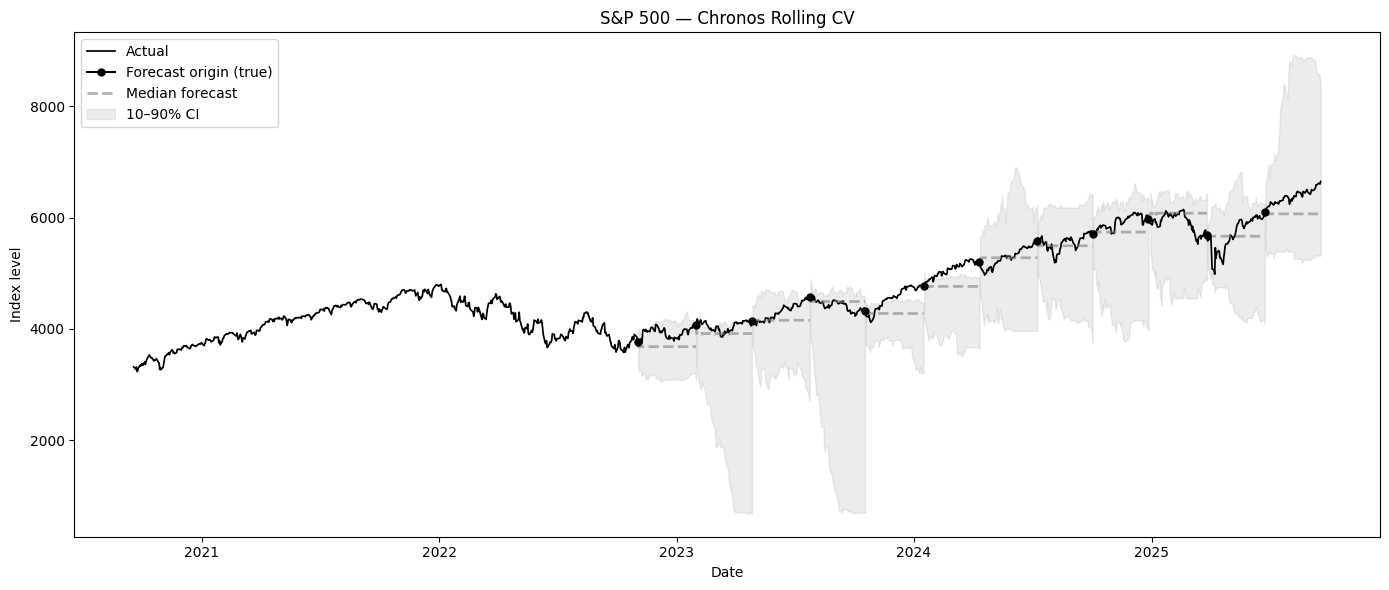

In [54]:
plot_forecast_eval(sp500_last5y, eval_df, "S&P 500 — Chronos Rolling CV", prediction_days)

In [55]:
eval_df.head(-5)

,true,low,median,high
Date,,,,
2022-11-03,3719.889893,3300.277035,3681.905161,3923.782143
2022-11-04,3770.550049,3246.526595,3681.905161,4007.095325
2022-11-07,3806.800049,3276.089337,3681.905161,3872.719224
2022-11-08,3828.110107,3168.588456,3681.905161,3870.031702
2022-11-09,3748.570068,3163.213412,3681.905161,3902.281967
...,...,...,...,...
2025-09-05,6481.500000,5277.317881,6065.373739,8832.423803
2025-09-08,6495.149902,5277.317881,6065.373739,8827.996523
2025-09-09,6512.609863,5277.317881,6065.373739,8836.851083
